In [1]:
# some ipython magic to automatically reload any imports if they change
# (useful when iterating locally)

from IPython import get_ipython

# do this so that formatter not messed up
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Load Model

In [2]:
import transformer_lens
import tqdm
import wandb

# load the device we'll use (GPU or MPS)
device = transformer_lens.utils.get_device()

print(f"Using device: {device}")

/home/ubuntu/minTranscoder/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
# load our model
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

/home/ubuntu/minTranscoder/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# sanity check with an example
example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = " Mary"
transformer_lens.utils.test_prompt(
    example_prompt,
    example_answer,
    model,
    prepend_bos=True,
)

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 70.07% Token: | Mary|

Top 0th token. Logit: 18.09 Prob: 70.07% Token: | Mary|
Top 1th token. Logit: 15.38 Prob:  4.67% Token: | the|
Top 2th token. Logit: 15.35 Prob:  4.54% Token: | John|
Top 3th token. Logit: 15.25 Prob:  4.11% Token: | them|
Top 4th token. Logit: 14.84 Prob:  2.73% Token: | his|
Top 5th token. Logit: 14.06 Prob:  1.24% Token: | her|
Top 6th token. Logit: 13.54 Prob:  0.74% Token: | a|
Top 7th token. Logit: 13.52 Prob:  0.73% Token: | their|
Top 8th token. Logit: 13.13 Prob:  0.49% Token: | Jesus|
Top 9th token. Logit: 12.97 Prob:  0.42% Token: | him|


Ranks of the answer tokens: [(' Mary', 0)]

# Define Transcoder Config

In [52]:
import dataclasses
import torch
from jaxtyping import Float

import torch.nn.functional as F

from min_transcoder.transcoder import (
    TranscoderResults,
    TranscoderConfig,
    Transcoder,
)


@dataclasses.dataclass
class TranscoderTrainingConfig:

    # Name of the layer to hook into for feature extraction
    hook_point: str
    out_hook_point: str

    num_epochs: int = 100

    # both from https://arxiv.org/html/2406.11944v1#S3 appendix E
    #
    # these are currently from https://github.com/jacobdunefsky/transcoder_circuits/blob/master/train_transcoder.py#L25 though
    # learning_rate: float = 0.0004 * 10
    # l1_coefficient: float = 0.0014 * 10
    learning_rate: float = 2 * 10e-3
    l1_coefficient: float = 5.5 * 10e-5

    @property
    def hook_point_layer(self) -> int:
        "Parse out the hook point layer as int ex: 'blocks.8.ln2.hook_normalized' -> 8"
        return int(self.hook_point.split(".")[1])


@dataclasses.dataclass
class TranscoderLoss:
    mse_loss: Float[torch.Tensor, ""]
    l1_loss: Float[torch.Tensor, ""]


def compute_loss(
    cfg: TranscoderTrainingConfig,
    mlp_out: Float[torch.Tensor, "batch seq d_model"],
    results: TranscoderResults,
) -> TranscoderLoss:
    # Compute MSE loss for each example in the batch
    mse_loss_per_example: Float[torch.Tensor, "batch"] = F.mse_loss(
        results.transcoder_out, mlp_out, reduction="none"
    ).mean(
        dim=(1, 2)
    )  # Mean across seq and d_model dimensions

    # Take the mean across the batch
    mse_loss = mse_loss_per_example.mean()

    # Compute L1 loss (sparsity regularization) on hidden activations
    sparsity: Float[torch.Tensor, "d_hidden"] = torch.abs(
        results.hidden_activations
    ).mean(dim=(0, 1))
    l1_loss = cfg.l1_coefficient * sparsity.sum()

    return TranscoderLoss(mse_loss=mse_loss, l1_loss=l1_loss)


# from https://arxiv.org/html/2406.11944v1#S3 appendix E
# transcoder_expansion_factor = 32
transcoder_expansion_factor = 64

transcoder_cfg = TranscoderConfig(
    d_in=model.cfg.d_model,
    d_out=model.cfg.d_model,
    # our transcoder has a hidden dimension of d_mlp * expansion factor
    d_hidden=model.cfg.d_mlp * transcoder_expansion_factor,
    dtype=model.cfg.dtype,
    device=device,
)

# Define training parameters
layer = 11

training_cfg = TranscoderTrainingConfig(
    num_epochs=5,
    hook_point=f"blocks.{layer}.ln2.hook_normalized",
    out_hook_point=f"blocks.{layer}.hook_mlp_out",
)

In [53]:
print(f"{model.cfg.n_layers=}")
print(f"{model.cfg.d_mlp=}")

model.cfg.n_layers=12
model.cfg.d_mlp=3072


# Load Data

In [7]:
import datasets
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


def create_tokenized_dataloader(
    max_length: int = 128,
    batch_size: int = 64,
    num_samples: int = 10000,
    shuffle: bool = True,
) -> DataLoader:

    print("Loading dataset...")
    dataset = datasets.load_dataset(
        path="NeelNanda/pile-10k",
        split="train",
        streaming=False,
    )

    print("Tokenizing dataset...")
    token_dataset = transformer_lens.utils.tokenize_and_concatenate(
        dataset=dataset,
        tokenizer=model.tokenizer,
        streaming=True,
        max_length=max_length,
        add_bos_token=model.cfg.default_prepend_bos,
    )

    # token_dataset['tokens'].shape=torch.Size([136625, 128])
    # print(f"{token_dataset['tokens'].shape=}")

    # shuffle, and arbitrarily cap at around 10,000 / 130,000 (original caps at ~24k)
    token_dataset = token_dataset.shuffle(42)
    token_dataset = token_dataset.take(num_samples)

    token_dataset_torch = torch.from_numpy(
        np.stack([x["tokens"] for x in token_dataset])
    ).cuda()

    # torch.Size([100, 1024])
    print(token_dataset_torch.shape)

    # Create a DataLoader for batching
    #
    # for batch in dataloader:
    #     print(batch.shape) # torch.Size([32, 1024])
    #     break
    #
    print(f"Creating dataloader for dataset...")
    dataloader = torch.utils.data.DataLoader(
        token_dataset_torch,
        batch_size=batch_size,
        shuffle=shuffle,
    )

    print(f"Num batches: {token_dataset_torch.shape[0] / batch_size}")

    return dataloader

# Collect Activations

Here we'll create hooks to store the MLP activations only

In [9]:
# store the MLP activations
mlp_inputs: list[Float[torch.Tensor, "batch seq d_mlp_in"]] = []
mlp_outputs: list[Float[torch.Tensor, "batch seq d_mlp_out"]] = []


# TODO(bschoen): Could make this general
def store_mlp_inputs(
    mlp_input: Float[torch.Tensor, "... d_in"],
    hook: transformer_lens.hook_points.HookPoint,
) -> None:

    # Detach and move to CPU to save memory
    mlp_inputs.append(mlp_input.detach().cpu())


def store_mlp_output(
    mlp_output: Float[torch.Tensor, "... d_out"],
    hook: transformer_lens.hook_points.HookPoint,
) -> None:

    # Detach and move to CPU to save memory
    mlp_outputs.append(mlp_output.detach().cpu())

In [10]:
dataloader = create_tokenized_dataloader()

# put model itself into eval mode so doesn't change
model.eval()

for batch_index, batch in tqdm.tqdm(
    enumerate(dataloader),
    desc="Collecting MLP activations",
):
    # move batch to device
    batch = batch.to(device)

    # Get MLP input and output activations
    model.run_with_hooks(
        batch,
        fwd_hooks=[
            (training_cfg.hook_point, store_mlp_inputs),
            (training_cfg.out_hook_point, store_mlp_output),
        ],
        return_type=None,
    )

Loading dataset...
Tokenizing dataset...
torch.Size([10000, 128])
Creating dataloader for dataset...
Num batches: 156.25


In [36]:
# now we can unload gpu
torch.cuda.empty_cache()

In [18]:
print(f"{len(mlp_inputs)=}, {mlp_inputs[0].shape=}")
print(f"{len(mlp_outputs)=}, {mlp_outputs[0].shape=}")

len(mlp_inputs)=157, mlp_inputs[0].shape=torch.Size([64, 128, 768])
len(mlp_outputs)=157, mlp_outputs[0].shape=torch.Size([64, 128, 768])


In [19]:
# Custom Dataset
class MLPActivationsDataset(Dataset):
    def __init__(
        self,
        mlp_inputs: list[Float[torch.Tensor, "batch seq d_mlp_in"]],
        mlp_outputs: list[Float[torch.Tensor, "batch seq d_mlp_out"]],
    ) -> None:
        self.mlp_inputs = mlp_inputs
        self.mlp_outputs = mlp_outputs
        assert len(self.mlp_inputs) == len(
            self.mlp_outputs
        ), "Inputs and outputs must be the same length."

    def __len__(self) -> int:
        return len(self.mlp_inputs)

    def __getitem__(self, idx: int) -> tuple[
        Float[torch.Tensor, "batch seq d_mlp_in"],
        Float[torch.Tensor, "batch seq d_mlp_out"],
    ]:
        x = self.mlp_inputs[idx]  # Shape: [128, 128, 768]
        y = self.mlp_outputs[idx]  # Shape: [128, 128, 768]
        return x, y


# Create Dataset and DataLoader
activations_dataset = MLPActivationsDataset(mlp_inputs, mlp_outputs)
activations_dataloader = DataLoader(
    activations_dataset,
    shuffle=True,
)

# Train Transcoder

In [56]:
# Initialize wandb
wandb.init(
    project="transcoder_training_v2",
    config=dataclasses.asdict(training_cfg),
)

transcoder = Transcoder(cfg=transcoder_cfg)

transcoder = transcoder.to(device)

# Initialize optimizer
optimizer = torch.optim.AdamW(transcoder.parameters(), lr=training_cfg.learning_rate)

num_steps = 0

# needed to track activation frequency
n_frac_active_tokens = 0
act_freq_scores = torch.zeros(transcoder.cfg.d_hidden, device=device)

# Training loop
for epoch in range(training_cfg.num_epochs):

    for batch_index, batch in tqdm.tqdm(
        enumerate(activations_dataloader),
        desc=f"Epoch {epoch+1}/{training_cfg.num_epochs}",
    ):

        # Do a training step.
        transcoder.train()

        # Make sure the W_dec is still zero-norm
        transcoder.set_decoder_norm_to_unit_norm()

        optimizer.zero_grad()

        # move batch to device
        batch_x, batch_y = batch

        mlp_in = batch_x[0].to(device)
        mlp_out = batch_y[0].to(device)

        # transcoder_results.transcoder_out: Float[Tensor, "... d_out"]
        # transcoder_results.hidden_activations: Float[Tensor, "... d_hidden"]
        transcoder_results = transcoder(mlp_in)

        # Compute loss
        loss_result = compute_loss(training_cfg, mlp_out, transcoder_results)

        loss = loss_result.mse_loss + loss_result.l1_loss

        # Backward pass and optimization
        loss.backward()

        optimizer.step()

        num_steps += 1

        # Calculate the sparsities, and add it to a list, calculate sparsity metrics
        #
        # transcoder_results.hidden_activations.shape=torch.Size([64, 128, 98304])
        #
        # act_freq_scores_update.shape=torch.Size([98304])
        #
        # Want to sum over both the seq and batch dimensions
        # act_freq_scores += (
        #    (transcoder_results.hidden_activations.abs() > 0).float().sum(dim=(0, 1))
        # )

        # Update the total number of tokens processed
        # batch_size * seq_len
        # n_frac_active_tokens += batch_x.shape[0] * batch_x.shape[1]

        # Calculate the mean activation frequency per neuron
        # Shape: [hidden_size]
        # feature_sparsity = act_freq_scores / n_frac_active_tokens

        # Print loss statistics every 10 batches
        if batch_index % 10 == 0:

            # Compute the mean activation over both batch and sequence dimensions
            # feature_sparsity.shape will be [hidden_size], i.e., [98304]
            feature_sparsity = (
                (transcoder_results.hidden_activations.abs() > 0)
                .float()
                .mean(dim=(0, 1))
            )

            # metrics for currents acts
            l0 = (transcoder_results.hidden_activations > 0).float().sum(-1).mean()

            # feature_sparsity.shape=torch.Size([128, 98304])

            print(
                f"Epoch {epoch+1}/{training_cfg.num_epochs}, "
                f"Batch {batch_index}/{len(activations_dataloader)}, "
                f"Loss: {loss.item():.6f}, "
                f"MSE Loss: {loss_result.mse_loss.item():.6f}, "
                f"L1 Loss: {loss_result.l1_loss.item():.6f}, "
                # f"Sparsity: {feature_sparsity.item():.6f}, "
                f"L0: {l0.item():.6f}"
            )

            # Log metrics to wandb
            wandb.log(
                {
                    "epoch": epoch + 1,
                    "loss": loss.item(),
                    "mse_loss": loss_result.mse_loss.item(),
                    "l1_loss": loss_result.l1_loss.item(),
                    "L0": l0.item(),
                    # "feature_sparsity": feature_sparsity.item(),
                    "sparsity/mean": feature_sparsity.mean().item(),
                    "sparsity_below_1e-5": (feature_sparsity < 1e-5)
                    .float()
                    .mean()
                    .item(),
                    "sparsity_below_1e-6": (feature_sparsity < 1e-6)
                    .float()
                    .mean()
                    .item(),
                },
                step=num_steps,
            )

    # Log model parameters and gradients
    # wandb.watch(transcoder)

print("Training completed!")

# Finish the wandb run
wandb.finish()

L0,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████
l1_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparsity/below_1e-5,▁███████████████████
sparsity/below_1e-6,▁███████████████████
sparsity/mean,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
L0,4.79834
epoch,2
l1_loss,3.23555


Epoch 1/5: 1it [00:00,  1.03it/s]

Epoch 1/5, Batch 0/157, Loss: 404.219513, MSE Loss: 19.778481, L1 Loss: 384.441040, L0: 98428.046875


Epoch 1/5: 11it [00:10,  1.18s/it]

Epoch 1/5, Batch 10/157, Loss: 19.403349, MSE Loss: 17.370590, L1 Loss: 2.032759, L0: 9.591675


Epoch 1/5: 21it [00:19,  1.18s/it]

Epoch 1/5, Batch 20/157, Loss: 11.988247, MSE Loss: 9.816299, L1 Loss: 2.171947, L0: 9.237549


Epoch 1/5: 31it [00:28,  1.18s/it]

Epoch 1/5, Batch 30/157, Loss: 10.846800, MSE Loss: 8.413660, L1 Loss: 2.433140, L0: 7.703857


Epoch 1/5: 41it [00:37,  1.18s/it]

Epoch 1/5, Batch 40/157, Loss: 9.840872, MSE Loss: 7.427976, L1 Loss: 2.412896, L0: 8.007080


Epoch 1/5: 51it [00:46,  1.18s/it]

Epoch 1/5, Batch 50/157, Loss: 9.332788, MSE Loss: 6.544838, L1 Loss: 2.787951, L0: 8.642700


Epoch 1/5: 61it [00:55,  1.18s/it]

Epoch 1/5, Batch 60/157, Loss: 9.389864, MSE Loss: 6.462059, L1 Loss: 2.927805, L0: 8.523682


Epoch 1/5: 71it [01:04,  1.18s/it]

Epoch 1/5, Batch 70/157, Loss: 9.291327, MSE Loss: 6.551067, L1 Loss: 2.740260, L0: 8.292114


Epoch 1/5: 81it [01:14,  1.18s/it]

Epoch 1/5, Batch 80/157, Loss: 9.320167, MSE Loss: 6.581285, L1 Loss: 2.738881, L0: 7.789429


Epoch 1/5: 91it [01:22,  1.16s/it]

Epoch 1/5, Batch 90/157, Loss: 9.303787, MSE Loss: 6.208385, L1 Loss: 3.095402, L0: 7.981689


Epoch 1/5: 101it [01:31,  1.18s/it]

Epoch 1/5, Batch 100/157, Loss: 8.857876, MSE Loss: 6.032262, L1 Loss: 2.825614, L0: 7.219727


Epoch 1/5: 111it [01:40,  1.18s/it]

Epoch 1/5, Batch 110/157, Loss: 8.843466, MSE Loss: 6.112745, L1 Loss: 2.730721, L0: 7.111328


Epoch 1/5: 121it [01:49,  1.18s/it]

Epoch 1/5, Batch 120/157, Loss: 8.688656, MSE Loss: 5.961963, L1 Loss: 2.726693, L0: 6.742310


Epoch 1/5: 131it [01:59,  1.18s/it]

Epoch 1/5, Batch 130/157, Loss: 8.949719, MSE Loss: 5.865077, L1 Loss: 3.084642, L0: 7.228516


Epoch 1/5: 141it [02:08,  1.18s/it]

Epoch 1/5, Batch 140/157, Loss: 8.797014, MSE Loss: 5.695395, L1 Loss: 3.101619, L0: 6.518188


Epoch 1/5: 151it [02:17,  1.18s/it]

Epoch 1/5, Batch 150/157, Loss: 7.990798, MSE Loss: 5.480648, L1 Loss: 2.510150, L0: 5.673950


Epoch 1/5: 157it [02:21,  1.11it/s]
Epoch 2/5: 1it [00:01,  1.85s/it]

Epoch 2/5, Batch 0/157, Loss: 7.921321, MSE Loss: 5.372721, L1 Loss: 2.548601, L0: 5.592529


Epoch 2/5: 11it [00:10,  1.19s/it]

Epoch 2/5, Batch 10/157, Loss: 8.753508, MSE Loss: 5.641742, L1 Loss: 3.111765, L0: 6.096069


Epoch 2/5: 21it [00:20,  1.18s/it]

Epoch 2/5, Batch 20/157, Loss: 8.047362, MSE Loss: 5.590727, L1 Loss: 2.456635, L0: 4.909790


Epoch 2/5: 31it [00:29,  1.18s/it]

Epoch 2/5, Batch 30/157, Loss: 8.345394, MSE Loss: 5.490322, L1 Loss: 2.855072, L0: 5.307739


Epoch 2/5: 41it [00:38,  1.18s/it]

Epoch 2/5, Batch 40/157, Loss: 8.823105, MSE Loss: 5.303054, L1 Loss: 3.520051, L0: 5.989868


Epoch 2/5: 51it [00:47,  1.18s/it]

Epoch 2/5, Batch 50/157, Loss: 8.654732, MSE Loss: 5.391063, L1 Loss: 3.263669, L0: 5.457153


Epoch 2/5: 61it [00:56,  1.18s/it]

Epoch 2/5, Batch 60/157, Loss: 8.426525, MSE Loss: 5.524925, L1 Loss: 2.901600, L0: 4.868042


Epoch 2/5: 71it [01:05,  1.18s/it]

Epoch 2/5, Batch 70/157, Loss: 8.419341, MSE Loss: 5.471136, L1 Loss: 2.948205, L0: 4.952759


Epoch 2/5: 81it [01:14,  1.18s/it]

Epoch 2/5, Batch 80/157, Loss: 8.130560, MSE Loss: 5.378008, L1 Loss: 2.752552, L0: 4.435181


Epoch 2/5: 91it [01:24,  1.18s/it]

Epoch 2/5, Batch 90/157, Loss: 8.345928, MSE Loss: 5.291148, L1 Loss: 3.054780, L0: 4.516602


Epoch 2/5: 101it [01:32,  1.13s/it]

Epoch 2/5, Batch 100/157, Loss: 7.873197, MSE Loss: 5.103437, L1 Loss: 2.769759, L0: 4.216797


Epoch 2/5: 111it [01:41,  1.18s/it]

Epoch 2/5, Batch 110/157, Loss: 7.873486, MSE Loss: 5.218347, L1 Loss: 2.655139, L0: 3.859863


Epoch 2/5: 121it [01:50,  1.18s/it]

Epoch 2/5, Batch 120/157, Loss: 8.056261, MSE Loss: 5.071133, L1 Loss: 2.985128, L0: 4.196777


Epoch 2/5: 131it [01:59,  1.18s/it]

Epoch 2/5, Batch 130/157, Loss: 8.193493, MSE Loss: 5.409389, L1 Loss: 2.784103, L0: 3.988647


Epoch 2/5: 141it [02:09,  1.18s/it]

Epoch 2/5, Batch 140/157, Loss: 8.194572, MSE Loss: 5.361913, L1 Loss: 2.832660, L0: 3.869751


Epoch 2/5: 151it [02:18,  1.18s/it]

Epoch 2/5, Batch 150/157, Loss: 8.399955, MSE Loss: 5.266769, L1 Loss: 3.133185, L0: 3.972534


Epoch 2/5: 157it [02:22,  1.10it/s]
Epoch 3/5: 1it [00:01,  1.85s/it]

Epoch 3/5, Batch 0/157, Loss: 8.437147, MSE Loss: 5.339080, L1 Loss: 3.098068, L0: 4.031616


Epoch 3/5: 11it [00:10,  1.19s/it]

Epoch 3/5, Batch 10/157, Loss: 8.331019, MSE Loss: 5.113410, L1 Loss: 3.217609, L0: 4.087402


Epoch 3/5: 21it [00:20,  1.18s/it]

Epoch 3/5, Batch 20/157, Loss: 7.699738, MSE Loss: 4.980385, L1 Loss: 2.719352, L0: 3.611450


Epoch 3/5: 31it [00:29,  1.18s/it]

Epoch 3/5, Batch 30/157, Loss: 7.861844, MSE Loss: 5.155126, L1 Loss: 2.706718, L0: 3.566406


Epoch 3/5: 41it [00:38,  1.18s/it]

Epoch 3/5, Batch 40/157, Loss: 7.913601, MSE Loss: 5.126004, L1 Loss: 2.787597, L0: 3.475830


Epoch 3/5: 51it [00:46,  1.11s/it]

Epoch 3/5, Batch 50/157, Loss: 7.430055, MSE Loss: 5.055471, L1 Loss: 2.374583, L0: 3.040405


Epoch 3/5: 61it [00:55,  1.18s/it]

Epoch 3/5, Batch 60/157, Loss: 7.285502, MSE Loss: 4.906403, L1 Loss: 2.379100, L0: 3.151367


Epoch 3/5: 71it [01:05,  1.18s/it]

Epoch 3/5, Batch 70/157, Loss: 7.703269, MSE Loss: 5.074435, L1 Loss: 2.628834, L0: 3.237427


Epoch 3/5: 81it [01:14,  1.18s/it]

Epoch 3/5, Batch 80/157, Loss: 7.859265, MSE Loss: 5.059564, L1 Loss: 2.799702, L0: 3.317139


Epoch 3/5: 91it [01:23,  1.18s/it]

Epoch 3/5, Batch 90/157, Loss: 7.664994, MSE Loss: 5.115911, L1 Loss: 2.549083, L0: 2.972656


Epoch 3/5: 101it [01:32,  1.18s/it]

Epoch 3/5, Batch 100/157, Loss: 8.084084, MSE Loss: 5.153798, L1 Loss: 2.930286, L0: 3.278687


Epoch 3/5: 111it [01:41,  1.18s/it]

Epoch 3/5, Batch 110/157, Loss: 7.923886, MSE Loss: 5.297754, L1 Loss: 2.626133, L0: 2.868896


Epoch 3/5: 121it [01:50,  1.18s/it]

Epoch 3/5, Batch 120/157, Loss: 8.145006, MSE Loss: 5.205588, L1 Loss: 2.939418, L0: 3.179077


Epoch 3/5: 131it [01:59,  1.18s/it]

Epoch 3/5, Batch 130/157, Loss: 7.839686, MSE Loss: 5.236441, L1 Loss: 2.603245, L0: 2.954346


Epoch 3/5: 141it [02:09,  1.18s/it]

Epoch 3/5, Batch 140/157, Loss: 7.848379, MSE Loss: 5.348078, L1 Loss: 2.500300, L0: 2.798096


Epoch 3/5: 151it [02:18,  1.18s/it]

Epoch 3/5, Batch 150/157, Loss: 7.887331, MSE Loss: 5.167045, L1 Loss: 2.720287, L0: 3.096558


Epoch 3/5: 157it [02:22,  1.10it/s]
Epoch 4/5: 1it [00:01,  1.85s/it]

Epoch 4/5, Batch 0/157, Loss: 7.774190, MSE Loss: 5.092923, L1 Loss: 2.681267, L0: 2.888062


Epoch 4/5: 11it [00:10,  1.12s/it]

Epoch 4/5, Batch 10/157, Loss: 7.931461, MSE Loss: 5.175066, L1 Loss: 2.756396, L0: 3.054077


Epoch 4/5: 21it [00:19,  1.18s/it]

Epoch 4/5, Batch 20/157, Loss: 7.623552, MSE Loss: 5.259244, L1 Loss: 2.364307, L0: 2.617554


Epoch 4/5: 31it [00:28,  1.18s/it]

Epoch 4/5, Batch 30/157, Loss: 7.590412, MSE Loss: 5.211813, L1 Loss: 2.378599, L0: 2.580078


Epoch 4/5: 41it [00:37,  1.18s/it]

Epoch 4/5, Batch 40/157, Loss: 7.554679, MSE Loss: 4.997985, L1 Loss: 2.556694, L0: 2.862305


Epoch 4/5: 51it [00:46,  1.18s/it]

Epoch 4/5, Batch 50/157, Loss: 7.810466, MSE Loss: 5.081104, L1 Loss: 2.729362, L0: 2.794922


Epoch 4/5: 61it [00:55,  1.18s/it]

Epoch 4/5, Batch 60/157, Loss: 7.657998, MSE Loss: 5.107058, L1 Loss: 2.550940, L0: 2.768188


Epoch 4/5: 71it [01:05,  1.18s/it]

Epoch 4/5, Batch 70/157, Loss: 7.613855, MSE Loss: 5.011988, L1 Loss: 2.601867, L0: 2.799805


Epoch 4/5: 81it [01:14,  1.18s/it]

Epoch 4/5, Batch 80/157, Loss: 7.443837, MSE Loss: 5.025614, L1 Loss: 2.418223, L0: 2.521362


Epoch 4/5: 91it [01:23,  1.18s/it]

Epoch 4/5, Batch 90/157, Loss: 7.692280, MSE Loss: 5.191890, L1 Loss: 2.500390, L0: 2.645020


Epoch 4/5: 101it [01:32,  1.18s/it]

Epoch 4/5, Batch 100/157, Loss: 7.909471, MSE Loss: 5.291245, L1 Loss: 2.618225, L0: 2.526001


Epoch 4/5: 111it [01:41,  1.18s/it]

Epoch 4/5, Batch 110/157, Loss: 7.645508, MSE Loss: 5.144480, L1 Loss: 2.501028, L0: 2.641846


Epoch 4/5: 121it [01:50,  1.18s/it]

Epoch 4/5, Batch 120/157, Loss: 7.838455, MSE Loss: 5.162842, L1 Loss: 2.675613, L0: 2.635254


Epoch 4/5: 131it [01:59,  1.18s/it]

Epoch 4/5, Batch 130/157, Loss: 8.001549, MSE Loss: 4.925291, L1 Loss: 3.076258, L0: 2.920654


Epoch 4/5: 141it [02:09,  1.18s/it]

Epoch 4/5, Batch 140/157, Loss: 7.882159, MSE Loss: 4.981211, L1 Loss: 2.900949, L0: 2.764893


Epoch 4/5: 151it [02:18,  1.18s/it]

Epoch 4/5, Batch 150/157, Loss: 7.693530, MSE Loss: 5.259905, L1 Loss: 2.433625, L0: 2.306152


Epoch 4/5: 157it [02:22,  1.10it/s]
Epoch 5/5: 1it [00:01,  1.85s/it]

Epoch 5/5, Batch 0/157, Loss: 7.717847, MSE Loss: 5.290228, L1 Loss: 2.427619, L0: 2.313232


Epoch 5/5: 11it [00:10,  1.19s/it]

Epoch 5/5, Batch 10/157, Loss: 7.492080, MSE Loss: 5.057593, L1 Loss: 2.434487, L0: 2.312744


Epoch 5/5: 21it [00:20,  1.18s/it]

Epoch 5/5, Batch 20/157, Loss: 7.350632, MSE Loss: 4.944596, L1 Loss: 2.406036, L0: 2.353027


Epoch 5/5: 31it [00:29,  1.18s/it]

Epoch 5/5, Batch 30/157, Loss: 7.439704, MSE Loss: 5.161452, L1 Loss: 2.278252, L0: 2.207764


Epoch 5/5: 41it [00:38,  1.18s/it]

Epoch 5/5, Batch 40/157, Loss: 7.747474, MSE Loss: 5.099888, L1 Loss: 2.647586, L0: 2.484863


Epoch 5/5: 51it [00:47,  1.18s/it]

Epoch 5/5, Batch 50/157, Loss: 7.302414, MSE Loss: 4.867785, L1 Loss: 2.434629, L0: 2.328857


Epoch 5/5: 61it [00:56,  1.18s/it]

Epoch 5/5, Batch 60/157, Loss: 7.851366, MSE Loss: 5.015822, L1 Loss: 2.835543, L0: 2.492676


Epoch 5/5: 71it [01:05,  1.18s/it]

Epoch 5/5, Batch 70/157, Loss: 7.517426, MSE Loss: 5.220969, L1 Loss: 2.296457, L0: 2.083740


Epoch 5/5: 81it [01:14,  1.18s/it]

Epoch 5/5, Batch 80/157, Loss: 7.473498, MSE Loss: 4.934245, L1 Loss: 2.539254, L0: 2.206299


Epoch 5/5: 91it [01:24,  1.18s/it]

Epoch 5/5, Batch 90/157, Loss: 7.751582, MSE Loss: 5.208167, L1 Loss: 2.543415, L0: 2.228638


Epoch 5/5: 101it [01:33,  1.18s/it]

Epoch 5/5, Batch 100/157, Loss: 7.298778, MSE Loss: 4.992640, L1 Loss: 2.306138, L0: 2.102905


Epoch 5/5: 111it [01:42,  1.18s/it]

Epoch 5/5, Batch 110/157, Loss: 7.281939, MSE Loss: 5.002841, L1 Loss: 2.279098, L0: 2.090210


Epoch 5/5: 121it [01:51,  1.18s/it]

Epoch 5/5, Batch 120/157, Loss: 7.757072, MSE Loss: 5.203391, L1 Loss: 2.553681, L0: 2.275635


Epoch 5/5: 131it [02:00,  1.18s/it]

Epoch 5/5, Batch 130/157, Loss: 7.259439, MSE Loss: 5.214679, L1 Loss: 2.044759, L0: 1.895874


Epoch 5/5: 141it [02:09,  1.18s/it]

Epoch 5/5, Batch 140/157, Loss: 7.510085, MSE Loss: 5.066212, L1 Loss: 2.443873, L0: 2.143311


Epoch 5/5: 151it [02:18,  1.05s/it]

Epoch 5/5, Batch 150/157, Loss: 7.178076, MSE Loss: 4.887732, L1 Loss: 2.290345, L0: 2.109375


Epoch 5/5: 157it [02:22,  1.10it/s]


Training completed!


L0,██▆▇▇▆▆▅▄▄▄▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆█████████
l1_loss,▂▃▆▇▆▄▇▃▆▆▅▇█▅▅▆▆▄▆▄▅▅▃▃▄▃▄▄▅▇▃▃▂▅▃▄▂▄▁▂
loss,█▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparsity/mean,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparsity_below_1e-5,▂█▇███████████▁▇███████████████████████▇
sparsity_below_1e-6,▁███████████████████████████████████████
L0,2.10938
epoch,5
l1_loss,2.29034


In [42]:
batch[1].shape

torch.Size([1, 64, 128, 768])

In [57]:
# Save the trained transcoder model to a file
import torch
import pathlib

# Define the path where you want to save the model
model_save_path = f"full_transcoder_model_{training_cfg.hook_point}.pth"

print(f"Transcoder model saved to {model_save_path}")

if not pathlib.Path(model_save_path).exists():
    torch.save(transcoder, model_save_path)

Transcoder model saved to full_transcoder_model_blocks.11.ln2.hook_normalized.pth


In [58]:
# Load the full transcoder model
loaded_transcoder = torch.load(model_save_path)

loaded_transcoder.to(device)

print("Loaded transcoder")

# Set the loaded model to evaluation mode
loaded_transcoder.eval()

print(loaded_transcoder)  # Print the loaded model architecture

# Optionally, you can verify the model's parameters
for name, param in loaded_transcoder.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")

/tmp/ipykernel_52487/3283311484.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_transcoder = torch.load(model_save_path)


Loaded transcoder
Transcoder()
Parameter: W_enc, Shape: torch.Size([768, 98304])
Parameter: b_enc, Shape: torch.Size([98304])
Parameter: W_dec, Shape: torch.Size([98304, 768])
Parameter: b_dec, Shape: torch.Size([768])
Parameter: b_dec_out, Shape: torch.Size([768])


# Compute Loss When Substituting MLP with Transcoder

In [59]:
class _TranscoderWrapper(torch.nn.Module):
    def __init__(self, transcoder: Transcoder):
        super().__init__()
        self.transcoder = transcoder

    def forward(
        self, x: Float[torch.Tensor, "... d_in"]
    ) -> Float[torch.Tensor, "... d_out"]:
        transcoder_result = self.transcoder(x)
        return transcoder_result.transcoder_out


@torch.no_grad()
def get_test_loss_when_replacing_mlp_with_transcoder(
    batch_tokens: Float[torch.Tensor, "batch seq"],
    transcoder: Transcoder,
    model: transformer_lens.HookedTransformer,
    hook_point_layer: str,
) -> Float[torch.Tensor, ""]:
    """
    A method for running the model with the SAE activations in order to return the
    loss returns per token loss when activations are substituted in.

    """
    old_mlp = model.blocks[hook_point_layer]

    model.blocks[hook_point_layer].mlp = _TranscoderWrapper(transcoder)

    ce_loss_with_recons = model.run_with_hooks(batch_tokens, return_type="loss")

    model.blocks[hook_point_layer] = old_mlp

    model.reset_hooks()

    return ce_loss_with_recons

In [60]:
# compute how much worse this makes the loss
#
# note: normally compare to ablated
#
transcoder = loaded_transcoder

transcoder.eval()

num_batches = 10

dataloader = create_tokenized_dataloader(num_samples=num_batches)

avg_loss_original = 0
avg_loss_when_replaced_mlp = 0

for batch_index, batch in enumerate(dataloader):

    if batch_index > num_batches:
        break

    batch = batch.to(device)

    loss_original = model.run_with_hooks(batch, return_type="loss")

    loss_when_replaced_mlp = get_test_loss_when_replacing_mlp_with_transcoder(
        batch_tokens=batch,
        transcoder=transcoder,
        model=model,
        hook_point_layer=training_cfg.hook_point_layer,
    )

    avg_loss_original += loss_original.item()
    avg_loss_when_replaced_mlp += loss_when_replaced_mlp.item()

avg_loss_original /= num_batches
avg_loss_when_replaced_mlp /= num_batches

print(f"{avg_loss_original=}")
print(f"{avg_loss_when_replaced_mlp=}")

Loading dataset...
Tokenizing dataset...
torch.Size([10, 128])
Creating dataloader for dataset...
Num batches: 0.15625
avg_loss_original=0.3654099225997925
avg_loss_when_replaced_mlp=0.371588921546936


# Sanity Check - Indirect Object Identification

We quickly check that IOI isn't impacted (it shouldn't be, since we know it
doesn't depend much on MLP, but it's good to check against a known result).

In [61]:
import transformer_lens

# sanity check with an example
example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = " Mary"
transformer_lens.utils.test_prompt(
    example_prompt,
    example_answer,
    model,
    prepend_bos=True,
)

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.39 Prob: 75.11% Token: | Mary|

Top 0th token. Logit: 18.39 Prob: 75.11% Token: | Mary|
Top 1th token. Logit: 15.74 Prob:  5.33% Token: | John|
Top 2th token. Logit: 15.69 Prob:  5.03% Token: | the|
Top 3th token. Logit: 14.92 Prob:  2.35% Token: | them|
Top 4th token. Logit: 14.24 Prob:  1.19% Token: | his|
Top 5th token. Logit: 13.88 Prob:  0.83% Token: | a|
Top 6th token. Logit: 13.34 Prob:  0.48% Token: | her|
Top 7th token. Logit: 13.26 Prob:  0.45% Token: | their|
Top 8th token. Logit: 13.25 Prob:  0.44% Token: | Jesus|
Top 9th token. Logit: 13.17 Prob:  0.41% Token: | Mrs|


Ranks of the answer tokens: [(' Mary', 0)]

In [62]:
import torch.nn as nn

old_mlp = model.blocks[training_cfg.hook_point_layer]

model.blocks[training_cfg.hook_point_layer].mlp = _TranscoderWrapper(transcoder)

transformer_lens.utils.test_prompt(
    example_prompt,
    example_answer,
    model,
    prepend_bos=True,
)

model.blocks[training_cfg.hook_point_layer] = old_mlp

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.39 Prob: 75.11% Token: | Mary|

Top 0th token. Logit: 18.39 Prob: 75.11% Token: | Mary|
Top 1th token. Logit: 15.74 Prob:  5.33% Token: | John|
Top 2th token. Logit: 15.69 Prob:  5.03% Token: | the|
Top 3th token. Logit: 14.92 Prob:  2.35% Token: | them|
Top 4th token. Logit: 14.24 Prob:  1.19% Token: | his|
Top 5th token. Logit: 13.88 Prob:  0.83% Token: | a|
Top 6th token. Logit: 13.34 Prob:  0.48% Token: | her|
Top 7th token. Logit: 13.26 Prob:  0.45% Token: | their|
Top 8th token. Logit: 13.25 Prob:  0.44% Token: | Jesus|
Top 9th token. Logit: 13.17 Prob:  0.41% Token: | Mrs|


Ranks of the answer tokens: [(' Mary', 0)]

# Differences In Generated Text

In [63]:
prompt = "The speech is about"

generated_text = model.generate(
    prompt,
    max_new_tokens=100,
    temperature=0,
    stop_at_eos=True,
)

print(generated_text)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 45.58it/s]

The speech is about the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "


In [64]:
prompt = "The speech is about"

old_mlp = model.blocks[training_cfg.hook_point_layer]

model.blocks[training_cfg.hook_point_layer].mlp = _TranscoderWrapper(transcoder)

generated_text = model.generate(
    prompt,
    max_new_tokens=100,
    temperature=0,
    stop_at_eos=True,
)

model.blocks[training_cfg.hook_point_layer] = old_mlp

print(generated_text)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 53.66it/s]

The speech is about the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "new" American culture of "self-expression," which is the "


# Top Activating Examples

In [65]:
# now we can unload gpu
torch.cuda.empty_cache()

In [66]:
# don't shuffle, that way we can lookup token batches by index
dataloader = create_tokenized_dataloader(num_samples=100, shuffle=False)

Loading dataset...
Tokenizing dataset...
torch.Size([100, 128])
Creating dataloader for dataset...
Num batches: 1.5625


In [67]:
# store the MLP activations
mlp_inputs: list[Float[torch.Tensor, "batch seq d_model"]] = []
mlp_outputs: list[Float[torch.Tensor, "batch seq d_model"]] = []
reconstructed_mlp_outputs: list[Float[torch.Tensor, "batch seq d_model"]] = []

# note: these in particular are absolutely huge
transcoder_hidden_activations: list[Float[torch.Tensor, "batch seq d_hidden"]] = []

# put model itself into eval mode so doesn't change
model.eval()
transcoder.eval()

for batch_index, batch in tqdm.tqdm(
    enumerate(dataloader),
    desc="Collecting MLP activations",
):
    # move batch to device
    batch = batch.to(device)

    # Get MLP input and output activations
    model.run_with_hooks(
        batch,
        fwd_hooks=[
            (training_cfg.hook_point, store_mlp_inputs),
            (training_cfg.out_hook_point, store_mlp_output),
        ],
        return_type=None,
    )

    # also reconstruct the mlp outputs using the transcoder
    mlp_input = mlp_inputs[-1].to(device)

    transcoder_result = transcoder(mlp_input)

    reconstructed_mlp_output = transcoder_result.transcoder_out
    transcoder_hidden_activation = transcoder_result.hidden_activations

    reconstructed_mlp_outputs.append(reconstructed_mlp_output.detach().cpu())
    transcoder_hidden_activations.append(transcoder_hidden_activation.detach().cpu())

In [32]:
# access corresponding batch directly
batch = dataloader.dataset[batch_index : batch_index + dataloader.batch_size]

print(batch.shape)

torch.Size([128, 128])


In [68]:
import einops


def stack_list_of_tensors(
    tensors: list[Float[torch.Tensor, "batch seq d_model"]]
) -> Float[torch.Tensor, "batch seq d_model"]:

    # Drop the last batch in case it doesn't match the rest of that shapes (ex: size 16 when batch size 128)
    if tensors[-1].shape[0] != tensors[0].shape[0]:
        tensors = tensors[:-1]

    return einops.rearrange(
        torch.stack(tensors),
        "num_batches batch seq d_model -> (num_batches batch) seq d_model",
    )


ResidualStream = Float[torch.Tensor, "batch seq d_model"]
TranscoderHidden = Float[torch.Tensor, "batch seq d_hidden"]

# Now we can safely stack the tensors
mlp_inputs_tensor: ResidualStream = stack_list_of_tensors(mlp_inputs)
mlp_outputs_tensor: ResidualStream = stack_list_of_tensors(mlp_outputs)
reconstructed_mlp_outputs_tensor: ResidualStream = stack_list_of_tensors(
    reconstructed_mlp_outputs
)
transcoder_hidden_activations_tensor: TranscoderHidden = stack_list_of_tensors(
    transcoder_hidden_activations
)

# mlp_inputs_tensor.shape=torch.Size([960, 128, 768])
# mlp_outputs_tensor.shape=torch.Size([960, 128, 768])
# reconstructed_mlp_outputs_tensor.shape=torch.Size([960, 128, 768])
# transcoder_hidden_activations_tensor.shape=torch.Size([960, 128, 98304])
print(f"{mlp_inputs_tensor.shape=}")
print(f"{mlp_outputs_tensor.shape=}")
print(f"{reconstructed_mlp_outputs_tensor.shape=}")
print(f"{transcoder_hidden_activations_tensor.shape=}")

mlp_inputs_tensor.shape=torch.Size([64, 128, 768])
mlp_outputs_tensor.shape=torch.Size([64, 128, 768])
reconstructed_mlp_outputs_tensor.shape=torch.Size([64, 128, 768])
transcoder_hidden_activations_tensor.shape=torch.Size([64, 128, 98304])


In [69]:
# reset these lists, since we no longer need this storage
mlp_inputs: list[Float[torch.Tensor, "batch seq d_model"]] = []
mlp_outputs: list[Float[torch.Tensor, "batch seq d_model"]] = []
reconstructed_mlp_outputs: list[Float[torch.Tensor, "batch seq d_model"]] = []
transcoder_hidden_activations: list[Float[torch.Tensor, "batch seq d_hidden"]] = []

In [70]:
# dataloader.dataset is `torch.Size([10000, 128])`
#
# (num_batches batch) seq
token_inputs_tensor = dataloader.dataset[: mlp_outputs_tensor.shape[0]]

# token_inputs_tensor.shape=torch.Size([9984, 128])
print(f"{token_inputs_tensor.shape=}")

token_inputs_tensor.shape=torch.Size([64, 128])


In [71]:
# now we can unload gpu
torch.cuda.empty_cache()

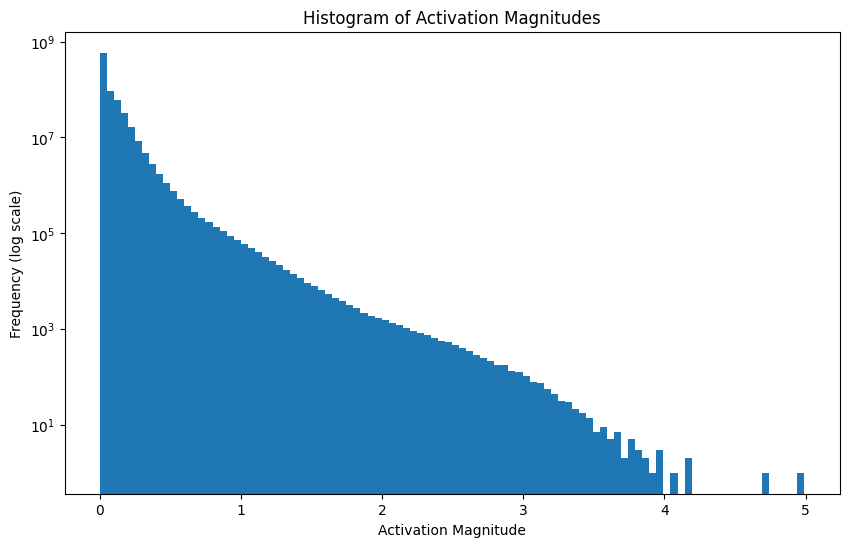

In [72]:
import matplotlib.pyplot as plt

# Flatten the activations to a 1D array
activations_flat = einops.rearrange(
    transcoder_hidden_activations_tensor.abs(),
    "batch seq d_hidden -> (batch seq d_hidden)",
)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(
    activations_flat, bins=100, log=True
)  # Use a logarithmic scale for better visibility
plt.title("Histogram of Activation Magnitudes")
plt.xlabel("Activation Magnitude")
plt.ylabel("Frequency (log scale)")
plt.show()

In [73]:
import numpy as np

percentiles = np.percentile(activations_flat, [90, 95, 99, 99.9])
print("Activation Magnitude Percentiles:")
for p, value in zip([90, 95, 99, 99.9], percentiles):
    print(f"{p}th percentile: {value}")

Activation Magnitude Percentiles:
90th percentile: 0.1388106346130371
95th percentile: 0.19501689076423645
99th percentile: 0.35799474507570395
99.9th percentile: 0.7767808316946514


In [75]:
# can set as number of standard deviations above mean
mean_activation = activations_flat.mean()
std_activation = activations_flat.std()

print(f"{mean_activation=}")
print(f"{std_activation=}")

num_std_dev_above_mean = 2

activation_threshold = mean_activation + num_std_dev_above_mean * std_activation

print(f"{activation_threshold=}")

mean_activation=tensor(0.0425)
std_activation=tensor(0.0835)
activation_threshold=tensor(0.2094)


Choose a threshold to determine if a dimension is active. Common choices are:
* A small positive number (e.g., 1e-3).
* A percentile of the activations.
* Mean or standard deviation-based threshold.

For simplicity, we'll use a small positive number:

In [76]:
activation_threshold = 1e-3

In [79]:
# Compute boolean mask of active dimensions
active_mask = activations_flat.abs() > activation_threshold

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(active_mask.cpu().numpy(), bins=50, kde=True)
plt.title("Histogram of Active Dimensions per Sample")
plt.xlabel("Number of Active Dimensions")
plt.ylabel("Frequency")
plt.show()

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [58]:
# Compute statistics
feature_means = samples.mean(dim=0)
feature_vars = samples.var(dim=0)
feature_max = samples.max(dim=0).values

# Optionally, compute absolute mean if activations can be negative
feature_abs_means = samples.abs().mean(dim=0)

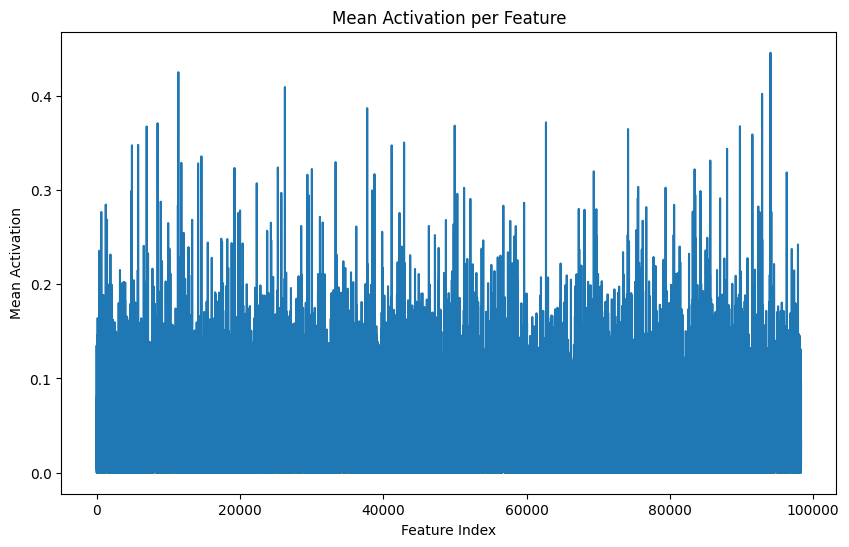

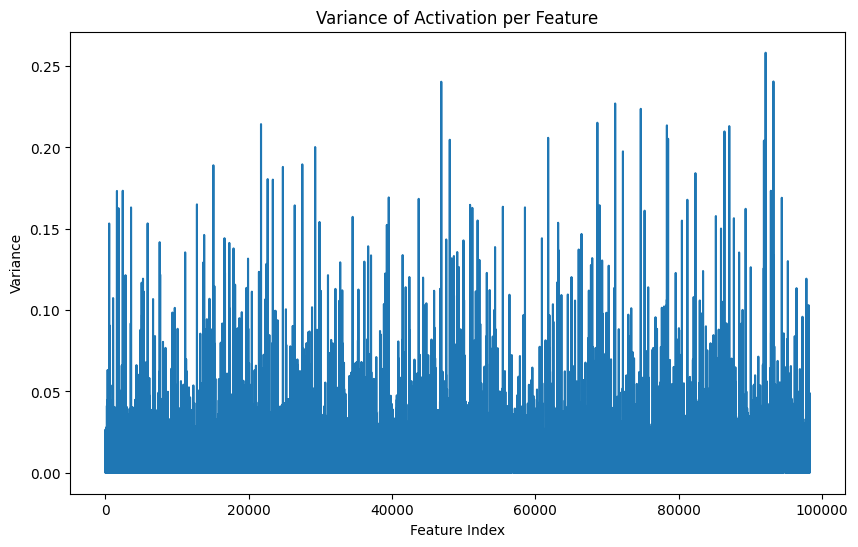

In [59]:
# Plot mean activations
plt.figure(figsize=(10, 6))
plt.plot(feature_means.cpu().numpy())
plt.title("Mean Activation per Feature")
plt.xlabel("Feature Index")
plt.ylabel("Mean Activation")
plt.show()

# Plot variance of activations
plt.figure(figsize=(10, 6))
plt.plot(feature_vars.cpu().numpy())
plt.title("Variance of Activation per Feature")
plt.xlabel("Feature Index")
plt.ylabel("Variance")
plt.show()

In [60]:
# Get top N features by mean activation
N = 10
top_features = torch.topk(feature_abs_means, N).indices
print(f"Top {N} features by absolute mean activation: {top_features}")

Top 10 features by absolute mean activation: tensor([94043, 11419, 26287, 92865, 37767, 62713,  8522, 49976, 89778,  7001])


In [61]:
# Ensure that the batch and sequence dimensions align between inputs and activations
assert (
    token_inputs_tensor.shape[0] == transcoder_hidden_activations_tensor.shape[0]
), "Batch size mismatch between inputs and activations."
assert (
    token_inputs_tensor.shape[1] == transcoder_hidden_activations_tensor.shape[1]
), "Sequence length mismatch between inputs and activations."

In [62]:
print(f"{top_features.shape=}")

top_features.shape=torch.Size([10])


In [67]:
for feature_idx in tqdm.tqdm(top_features, desc="Finding top features"):
    # Get activations for this feature across all samples
    feature_activations = samples[:, feature_idx]
    # Get top K samples with highest activations
    K = 5
    topk = torch.topk(feature_activations, K)

    topk_values = topk.values
    topk_indices = topk.indices

    print(f"\nTop {K} samples activating Feature {feature_idx.item()}:")
    for i, idx in enumerate(topk_indices):
        # Map back to batch and sequence indices
        sample_idx = idx.item()
        batch_idx = sample_idx // transcoder_hidden_activations_tensor.shape[1]
        seq_idx = sample_idx % transcoder_hidden_activations_tensor.shape[1]

        input_token_seq = token_inputs_tensor[batch_idx]
        input_token = input_token_seq[seq_idx]
        input_token_seq_str = model.tokenizer.decode(input_token_seq.tolist())
        input_token_str = model.tokenizer.decode(input_token.item())
        activation_value = topk_values[i].item()

        print(f"Sample {i+1}:")
        print(f"  Batch index: {batch_idx}, Sequence index: {seq_idx}")
        print(f"  Input token seq: {input_token_seq_str}")
        print(f"  Input token: {input_token_str}")
        print(f"  Activation value: {activation_value}")

Finding top features:   0%|          | 0/10 [00:00<?, ?it/s]

Finding top features: 100%|██████████| 10/10 [00:00<00:00, 117.07it/s]


Top 5 samples activating Feature 94043:
Sample 1:
  Batch index: 728, Sequence index: 106
  Input token seq: <|endoftext|> a future? We can't do it without you.var arrayCopy = require('./arrayCopy'),
    isArguments = require('../lang/isArguments'),
    isArray = require('../lang/isArray'),
    isArrayLike = require('./isArrayLike'),
    isPlainObject = require('../lang/isPlainObject'),
    isTypedArray = require('../lang/isTypedArray'),
    toPlainObject = require('../lang/toPlainObject');
  Input token: ed
  Activation value: 1.1754902601242065
Sample 2:
  Batch index: 550, Sequence index: 105
  Input token seq: <|endoftext|> as I can."

The queen departed with her head bowed.

Verasa watched her go with some puzzlement. "Didn't you once tell me Queen Malveria waded through a river of blood to kill a dragon?"

"She did."

"It seems unlikely."

"There aren't any dragons left," said Thrix, defensively. "These days she's more interested in fashion."

"You seem to have been an excellent

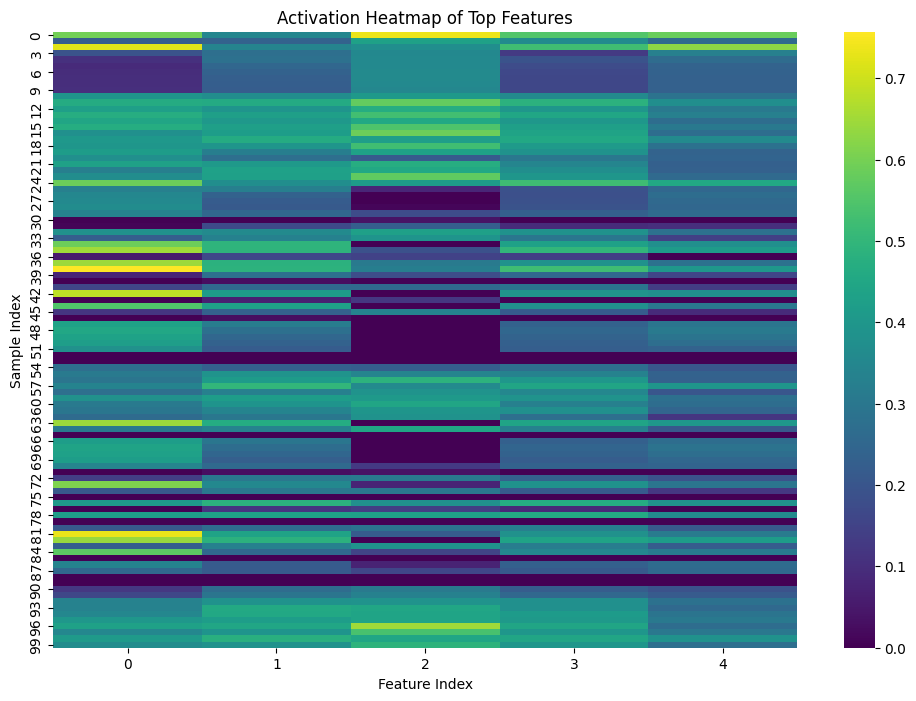

In [65]:
import numpy as np

# Select a subset of data for visualization
num_samples_to_plot = 100
features_to_plot = top_features[:5]  # Select top 5 features
activations_subset = samples[:num_samples_to_plot, features_to_plot]

plt.figure(figsize=(12, 8))
sns.heatmap(activations_subset.cpu().numpy(), cmap="viridis")
plt.title("Activation Heatmap of Top Features")
plt.xlabel("Feature Index")
plt.ylabel("Sample Index")
plt.show()